In [ ]:
! pip install pennylane
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 55.2 MB/s eta 0:00:00


We proceed right away to create a dataset to work with, the Double Moons dataset. Firstly, we define two functions to enable us to generate the data.

In [ ]:
def _make_moons_data(num_samples, noise=0.05):
    """Generate datapoints arranged in two interleaving half circles (moons)."""
    x = np.random.normal(0, noise, num_samples)
    y = np.random.normal(0, noise, num_samples)
    labels = np.zeros(num_samples)

    for i in range(num_samples):
        if y[i] > x[i]**2 - 0.5:
            labels[i] = 1
        else:
            labels[i] = -1

    return x, y, labels


def make_double_moons_data(num_samples, noise=0.05):
    x1, y1, labels1 = _make_moons_data(num_samples, noise)
    x2, y2, labels2 = _make_moons_data(num_samples, noise)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, x2 ])
    y = np.hstack([y1, y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

Next, we define a function to help plot the Double Moons data

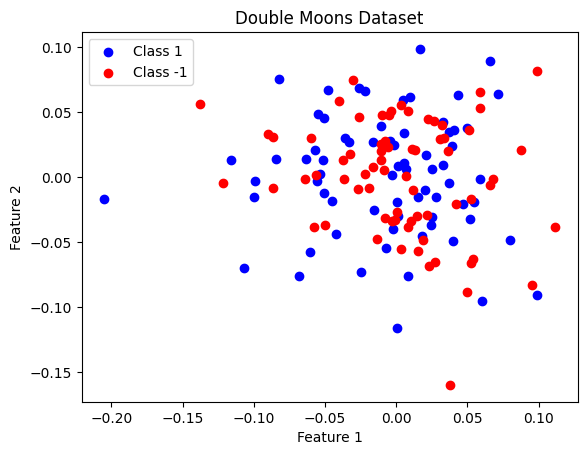

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    ax.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', label='Class 1')
    ax.scatter(X[Y == -1, 0], X[Y == -1, 1], c='r', label='Class -1')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Double Moons Dataset')
    ax.legend()
    return ax
num_samples = 70
X, Y = make_double_moons_data(num_samples)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=None)
plt.show()

#Defining a Quantum Embedding Kernel
PennyLane’s kernels module allows for a particularly simple implementation of Quantum Embedding Kernels. The first ingredient we need for this is an ansatz, which we will construct by repeating a layer as building block. Let’s start by defining this layer:

In [ ]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])


In [ ]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires))

In [ ]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

In [ ]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

In [ ]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [ ]:
init_params = random_params(num_wires=5, num_layers=6)

In [ ]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")


The kernel value between the first and second datapoint is 0.904


In [ ]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.904 0.962 ... 0.952 0.927 0.948]
 [0.904 1.    0.971 ... 0.99  0.954 0.993]
 [0.962 0.971 1.    ... 0.992 0.926 0.99 ]
 ...
 [0.952 0.99  0.992 ... 1.    0.96  1.   ]
 [0.927 0.954 0.926 ... 0.96  1.    0.961]
 [0.948 0.993 0.99  ... 1.    0.961 1.   ]]


In [ ]:
from sklearn.svm import SVC

In [ ]:
# Define the SVM with the custom kernel
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel))

# Fit the SVM model
svm.fit(X, Y)

In [ ]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")


The accuracy of the kernel with random parameters is 0.870


We are also interested in seeing what the decision boundaries in this classification look like. This could help us spotting overfitting issues visually in more complex data sets. To this end we will introduce a second helper method.



In [ ]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1.5, 2.5, N_gridpoints), np.linspace(-1, 1.5, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 2.5],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

<ipython-input-105-2d8736b8fdf6>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])


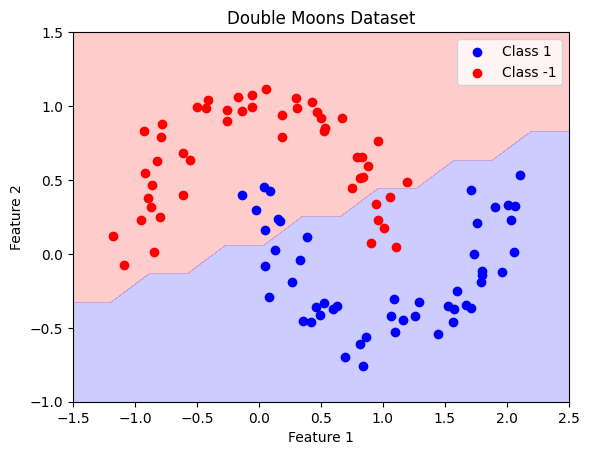

In [ ]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

We see the outer points in the dataset can be correctly classified, but we still struggle with the inner ones. It is reasonable to believe we can give values to those variational parameters which improve the overall accuracy of our SVC.

In [ ]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.364


In [ ]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

In [ ]:
def cost_with_regularization(params, X, Y, kernel, reg_lambda=0.01):
    kta = differentiable_kta(X, Y, lambda X1, X2: kernel(X1, X2, params))
    regularization = reg_lambda * np.sum(params**2)  # L2 regularization
    return -kta + regularization


In [ ]:
# Optimization loop with regularization for RBF kernel
for step in range(num_steps):
    indices = np.random.choice(len(X), batch_size, replace=False)
    X_batch = X[indices]
    Y_batch = Y[indices]
    params = opt.step(lambda v: cost_with_regularization(v, X_batch, Y_batch, rbf_kernel), params)

    if step % 50 == 0:
        current_kta = differentiable_kta(X_batch, Y_batch, lambda X1, X2: rbf_kernel(X1, X2, params))
        print(f"Step {step}: KTA = {current_kta:.3f}, params = {params}")

# Final KTA on the entire dataset for RBF kernel with regularization
final_kta = differentiable_kta(X, Y, lambda X1, X2: rbf_kernel(X1, X2, params))
print(f"The final kernel-target alignment for our dataset with regularization is {final_kta:.3f}")


Step 0: KTA = 0.338, params = [1.07131225]
Step 50: KTA = 0.788, params = [1.06643578]
Step 100: KTA = 0.254, params = [1.06372214]
Step 150: KTA = 0.377, params = [1.06023673]
Step 200: KTA = 0.435, params = [1.05333156]
Step 250: KTA = 0.440, params = [1.05664783]
Step 300: KTA = 0.505, params = [1.06513829]
Step 350: KTA = 0.538, params = [1.05961706]
Step 400: KTA = 0.527, params = [1.05820977]
Step 450: KTA = 0.382, params = [1.05712178]
The final kernel-target alignment for our dataset with regularization is 0.440


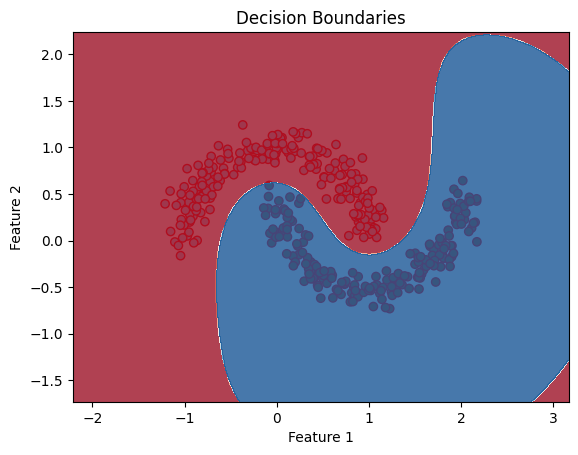

Accuracy on the training set: 1.000
Accuracy on the test set: 1.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model):
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='r')

    # Create a meshgrid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the labels for the meshgrid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries')

    plt.show()

# Generate the double moons dataset
num_samples = 500
X, y = make_moons(n_samples=num_samples, noise=0.1, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_boundaries(X_train, y_train, svm_model)

# Calculate accuracy on the training set
y_pred_train = svm_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on the training set: {accuracy_train:.3f}")

# Calculate accuracy on the test set
y_pred_test = svm_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on the test set: {accuracy_test:.3f}")


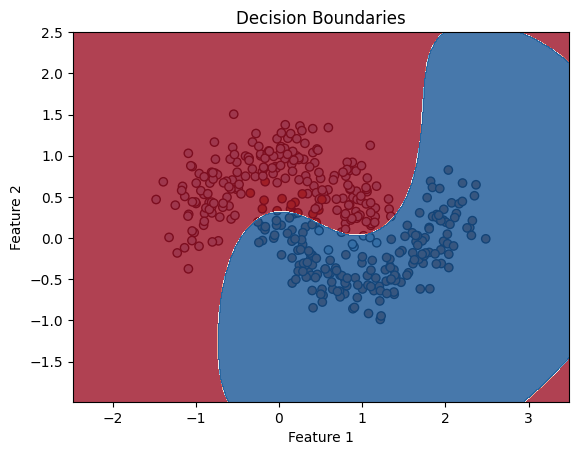

Accuracy on the training set: 0.945
Accuracy on the test set: 0.920


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model):
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    # Create a meshgrid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the labels for the meshgrid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries')

    plt.show()

# Generate the double moons dataset
num_samples = 500
X, y = make_moons(n_samples=num_samples, noise=0.2, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM model with modified parameters
svm_model = SVC(kernel='rbf', C=0.1, gamma=1)  # Decrease C and increase gamma
svm_model.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_boundaries(X_train, y_train, svm_model)

# Calculate accuracy on the training set
y_pred_train = svm_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on the training set: {accuracy_train:.3f}")

# Calculate accuracy on the test set
y_pred_test = svm_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on the test set: {accuracy_test:.3f}")


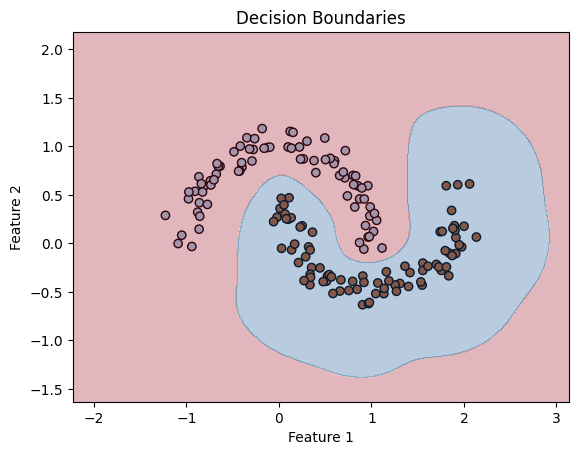

Accuracy on the training set: 1.000
Accuracy on the test set: 0.975


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model):
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    # Create a meshgrid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the labels for the meshgrid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries')

    plt.show()

# Generate the double moons dataset with scattered data points
num_samples = 200  # Decrease number of samples
X, y = make_moons(n_samples=num_samples, noise=0.1, random_state=42)  # Decrease noise level

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM model with modified parameters
svm_model = SVC(kernel='rbf', C=100, gamma=10)  # Adjust parameters for better performance
svm_model.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_boundaries(X_train, y_train, svm_model)

# Calculate accuracy on the training set
y_pred_train = svm_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on the training set: {accuracy_train:.3f}")

# Calculate accuracy on the test set
y_pred_test = svm_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on the test set: {accuracy_test:.3f}")